# TorchVision Object Detection Finetuning Tutorial

Here are Kaggle notebooks about this tutorial:

- [TorchVision Faster R-CNN Finetuning](https://www.kaggle.com/gocoding/torchvision-faster-r-cnn-finetuning)
- [TorchVision Faster R-CNN Inference](https://www.kaggle.com/gocoding/torchvision-faster-r-cnn-inference)

## Prepare Dataset

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

### Download Data

Download the dataset from [Kaggle: Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection) `data` and list its contents:

- train.csv - the training data
- sample_submission.csv - a sample submission file in the correct format
- train.zip - training images
- test.zip - test images

In [2]:
DIR_INPUT = 'global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

### Read Data

Read the `train.csv` data:

In [3]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


- image_id - the unique image ID
- width, height - the width and height of the images
- bbox - a bounding box, formatted as a Python-style list of [xmin, ymin, width, height]
- etc.


Split`bbox` to `x` `y` `w` `h`:

In [4]:
train_df[['x','y','w','h']] = 0
train_df[['x','y','w','h']] = np.stack(train_df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=','))).astype(np.float)
train_df.drop(columns=['bbox'], inplace=True)
train_df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


### Analysis Dataset

The size of train data:

In [5]:
train_df.shape

(147793, 8)

The number of unique `image_id` in train data:

In [6]:
train_df['image_id'].nunique()

3373

The number of images in train dir:

In [7]:
len(os.listdir(DIR_TRAIN))

3423

There are `3422-3373=49` images which do not have any wheat heads in it (without annotation). 


Distribution of size of train images:

In [8]:
train_df['width'].unique(), train_df['height'].unique()

(array([1024]), array([1024]))

Distribution of number of bounding boxes:

number of boxes, range [1, 116]


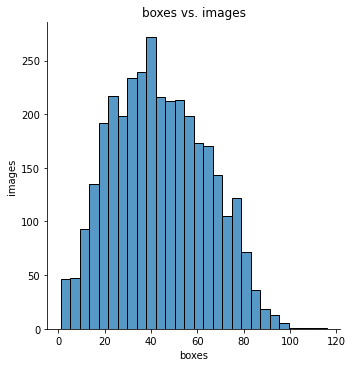

In [9]:
counts = train_df['image_id'].value_counts()
print(f'number of boxes, range [{min(counts)}, {max(counts)}]')
sns.displot(counts, kde=False)
plt.xlabel('boxes')
plt.ylabel('images')
plt.title('boxes vs. images')
plt.show()

Distribution of size of bounding boxes:

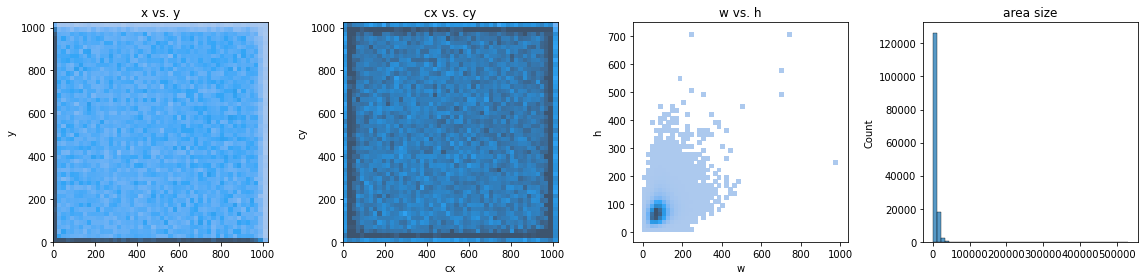

In [10]:
train_df['cx'] = train_df['x'] + train_df['w'] / 2
train_df['cy'] = train_df['y'] + train_df['h'] / 2

ax = plt.subplots(1, 4, figsize=(16, 4), tight_layout=True)[1].ravel()
ax[0].set_title('x vs. y')
ax[0].set_xlim(0, 1024)
ax[0].set_ylim(0, 1024)
ax[1].set_title('cx vs. cy')
ax[1].set_xlim(0, 1024)
ax[1].set_ylim(0, 1024)
ax[2].set_title('w vs. h')
ax[3].set_title('area size')
sns.histplot(data=train_df, x='x', y='y', ax=ax[0], bins=50, pmax=0.9)
sns.histplot(data=train_df, x='cx', y='cy', ax=ax[1], bins=50, pmax=0.9)
sns.histplot(data=train_df, x='w', y='h', ax=ax[2], bins=50, pmax=0.9)
sns.histplot(train_df['w'] * train_df['h'], ax=ax[3], bins=50, kde=False)
plt.show()

Split dataset to `train:valid=8:2`:

In [11]:
image_ids = train_df['image_id'].unique()

split_len = round(len(image_ids)*0.8)

train_ids = image_ids[:split_len]
valid_ids = image_ids[split_len:]

train = train_df[train_df['image_id'].isin(train_ids)]
valid = train_df[train_df['image_id'].isin(valid_ids)]

train.shape, valid.shape

((122577, 10), (25216, 10))

### Show Images

In [12]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles and len(titles) > i:
      ax.set_title(titles[i])
  return axes

def show_bboxes(axes, bboxes, labels=None, colors=None):
  def _make_list(obj, default_values=None):
    if obj is None:
      obj = default_values
    elif not isinstance(obj, (list, tuple)):
      obj = [obj]
    return obj

  labels = _make_list(labels)
  colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
  for i, bbox in enumerate(bboxes):
    color = colors[i % len(colors)]
    rect = plt.Rectangle(
      xy=(bbox[0], bbox[1]),
      width=bbox[2] - bbox[0],
      height=bbox[3] - bbox[1],
      fill=False,
      edgecolor=color,
      linewidth=2)
    axes.add_patch(rect)
    if labels and len(labels) > i:
      text_color = 'k' if color == 'w' else 'w'
      axes.text(rect.xy[0], rect.xy[1], labels[i], va='center',
                ha='center', fontsize=9, color=text_color,
                bbox=dict(facecolor=color, lw=0))

# https://github.com/d2l-ai/d2l-en/blob/master/d2l/torch.py

Show images without `bboxes`:

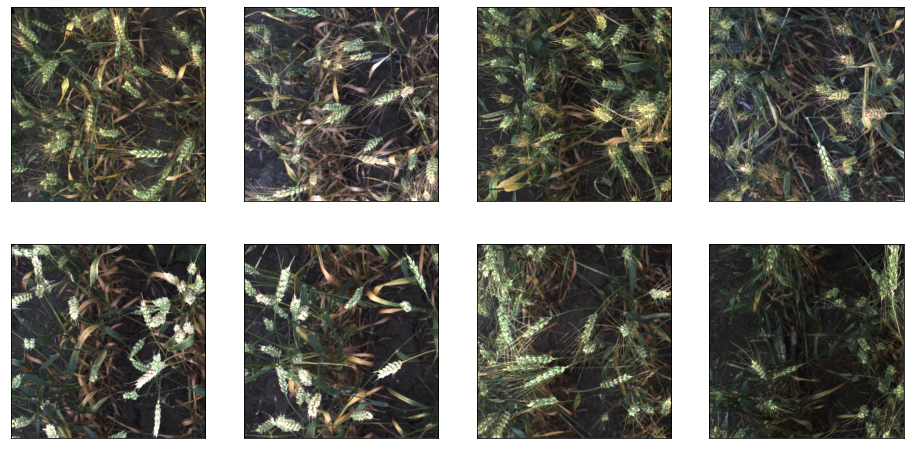

In [13]:
num_rows, num_cols = 2, 4
imgs = [plt.imread(f'{DIR_TRAIN}/{n}.jpg') for n in train_df['image_id'].unique()[:num_rows*num_cols]]
show_images(imgs, num_rows, num_cols, scale=4)
plt.show()

Show images with `bboxes`:

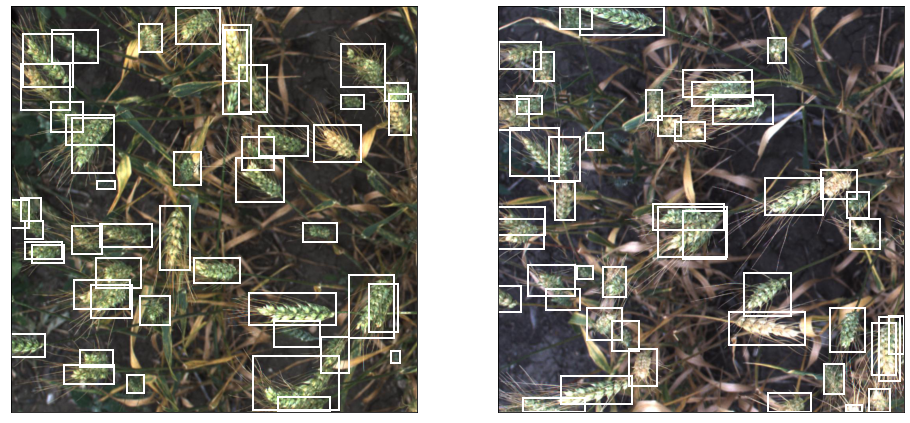

In [14]:
num_rows, num_cols = 1, 2
ids = train_df['image_id'].unique()[:num_rows*num_cols]
imgs = [plt.imread(f'{DIR_TRAIN}/{n}.jpg') for n in ids]
axes = show_images(imgs, num_rows, num_cols, scale=8)
for ax, id in zip(axes, ids):
  datas = train_df[train_df['image_id'] == id]
  bboxes = [(d['x'], d['y'], d['x']+d['w'], d['y']+d['h']) for _, d in datas.iterrows()]
  show_bboxes(ax, bboxes, labels=None, colors=['w'])
plt.show()

### Create Dataset

The dataset should inherit from the standard [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a `numpy.ndarray` image
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.

In [15]:
import cv2 as cv
import numpy as np

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch.utils.data import Dataset


class Wheat(Dataset):

  def __init__(self, dataframe, image_dir, transforms=None):
    super().__init__()
    self.image_ids = dataframe['image_id'].unique()
    self.df = dataframe
    self.image_dir = image_dir
    self.transforms = transforms

  def __getitem__(self, idx: int):
    image_id = self.image_ids[idx]
    records = self.df[self.df['image_id'] == image_id]

    image = cv.imread(f'{self.image_dir}/{image_id}.jpg', cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    boxes = records[['x', 'y', 'w', 'h']].values

    area = boxes[:, 2] * boxes[:, 3]
    area = torch.as_tensor(area, dtype=torch.float32)

    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

    # there is only one class
    labels = torch.ones((records.shape[0],), dtype=torch.int64)
    # suppose all instances are not crowd
    iscrowd = torch.zeros((records.shape[0],), dtype=torch.uint8)

    target = {}
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = torch.tensor([idx])
    target['area'] = area
    target['iscrowd'] = iscrowd

    if self.transforms:
      sample = {
        'image': image,
        'bboxes': target['boxes'],
        'labels': labels,
      }
      sample = self.transforms(**sample)
      image = sample['image']
      target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

    return image, target, image_id

  def __len__(self) -> int:
    return len(self.image_ids)

  # albumentations
  #  https://github.com/albumentations-team/albumentations

  @staticmethod
  def get_train_transform():
    return A.Compose([
      A.Flip(0.5),
      ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

  @staticmethod
  def get_valid_transform():
    return A.Compose([
      ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

Create `train` `valid` datasets:

In [16]:
train_dataset = Wheat(train, DIR_TRAIN, Wheat.get_train_transform())
valid_dataset = Wheat(valid, DIR_TRAIN, Wheat.get_valid_transform())

Show images with `transforms`:

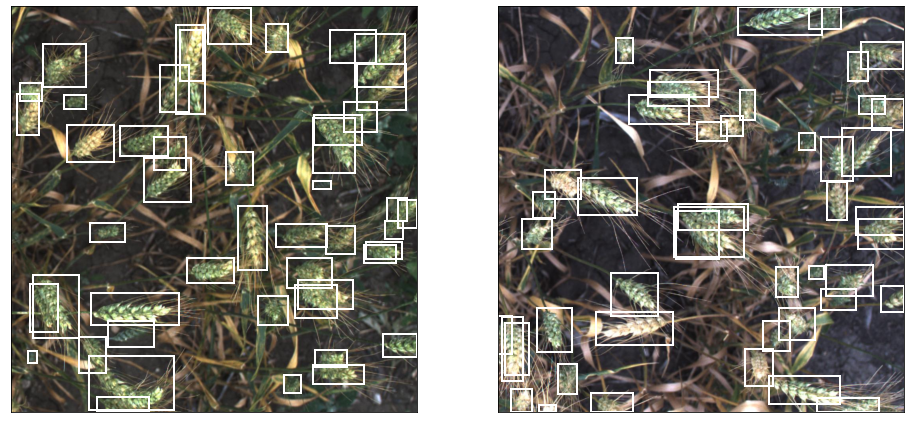

In [17]:
datas = [train_dataset[i] for i in range(2)]
imgs = [d[0].permute(1, 2, 0).numpy() for d in datas]
axes = show_images(imgs, 1, 2, scale=8)
for ax, (image, target, image_id) in zip(axes, datas):
  show_bboxes(ax, target['boxes'], labels=None, colors=['w'])
plt.show()

## Prepare Model

In [18]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

### Create Model

Create a Faster R-CNN model pre-trained on COCO:

In [19]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

### Finetune Model

Print the last layer:

In [20]:
print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)


Finetune the last layer:

In [21]:
num_classes = 2 # wheat or not(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Print the last layer again:

In [22]:
print(model.roi_heads.box_predictor)

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)


## Train Model

### Create DataLoader

In [23]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  return tuple(zip(*batch))

train_data_loader = DataLoader(
  train_dataset,
  batch_size=4,
  shuffle=False,
  num_workers=4,
  collate_fn=collate_fn
)

valid_data_loader = DataLoader(
  valid_dataset,
  batch_size=4,
  shuffle=False,
  num_workers=4,
  collate_fn=collate_fn
)

### Create Params 

In [24]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# move model to the right device
model.to(device)

# create an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# create a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

# train it for 2 epochs
num_epochs = 2

### Let's Train

In [25]:
import time
from tqdm import tqdm 
#from tqdm.notebook import tqdm as tqdm

itr = 1

total_train_loss = []
total_valid_loss = []

losses_value = 0

for epoch in range(num_epochs):

  start_time = time.time()

  # train ------------------------------

  model.train()
  train_loss = []
  
  pbar = tqdm(train_data_loader, desc='let\'s train')
  for images, targets, image_ids in pbar:
    
    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    losses_value = losses.item()
    train_loss.append(losses_value)   

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    pbar.set_description(f"Epoch: {epoch+1}, Batch: {itr}, Loss: {losses_value}")
    itr += 1
  
  epoch_train_loss = np.mean(train_loss)
  total_train_loss.append(epoch_train_loss)

  # update the learning rate
  if lr_scheduler is not None:
    lr_scheduler.step()

  # valid ------------------------------

  with torch.no_grad():
    valid_loss = []

    for images, targets, image_ids in valid_data_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

      loss_dict = model(images, targets)

      losses = sum(loss for loss in loss_dict.values())
      loss_value = losses.item()
      valid_loss.append(loss_value)
        
  epoch_valid_loss = np.mean(valid_loss)
  total_valid_loss.append(epoch_valid_loss)    
  
  # print ------------------------------

  print(f"Epoch Completed: {epoch+1}/{num_epochs}, Time: {time.time()-start_time}, "
        f"Train Loss: {epoch_train_loss}, Valid Loss: {epoch_valid_loss}")

let's train:   0%|          | 0/675 [00:00<?, ?it/s]

Epoch Completed: 1/2, Time: 566.7130048274994, Train Loss: 0.909390335455138, Valid Loss: 0.8790632066434829


Epoch: 2, Batch: 1350, Loss: 0.8195391336080114: 100%|██████████| 675/675 [08:27<00:00,  1.33it/s] 


Epoch Completed: 2/2, Time: 569.5055477619171, Train Loss: 0.8158109236268262, Valid Loss: 0.8743081629490502


### Show Loss

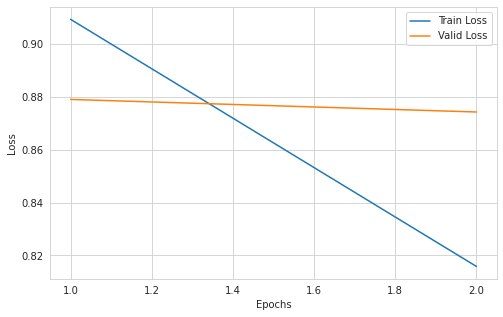

In [26]:
plt.figure(figsize=(8, 5))
sns.set_style(style="whitegrid")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_train_loss, label="Train Loss")
sns.lineplot(x=range(1, len(total_train_loss)+1), y=total_valid_loss, label="Valid Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

## Save Model

In [27]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

## Inference with Model

### Prepare Data

- [Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection)
- [TorchVision Faster R-CNN Finetuning](https://www.kaggle.com/gocoding/torchvision-faster-r-cnn-finetuning)

In [28]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

DIR_INPUT = 'global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

WEIGHTS_FILE = 'fasterrcnn_resnet50_fpn.pth'

#### Submission File

The submission format requires a space delimited set of bounding boxes. For example:

`ce4833752,0.5 0 0 100 100`

indicates that image `ce4833752` has a bounding box with a confidence of `0.5`, at `x` == 0 and `y` == 0, with a `width` and `height` of 100.

In [29]:
test_df = pd.read_csv(f'{DIR_INPUT}/sample_submission.csv')
test_df.tail()

,image_id,PredictionString
5,348a992bb,1.0 0 0 50 50
6,cc3532ff6,1.0 0 0 50 50
7,2fd875eaa,1.0 0 0 50 50
8,cb8d261a3,1.0 0 0 50 50
9,53f253011,1.0 0 0 50 50


#### Create Dataset

In [30]:
import cv2 as cv
import numpy as np

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
from torch.utils.data import Dataset


class WheatTest(Dataset):

  def __init__(self, image_ids, image_dir, transforms=None):
    super().__init__()
    self.image_ids = image_ids
    self.image_dir = image_dir
    self.transforms = transforms

  def __getitem__(self, idx: int):
    image_id = self.image_ids[idx]

    image = cv.imread(f'{self.image_dir}/{image_id}.jpg', cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    if self.transforms:
      sample = {
        'image': image,
      }
      sample = self.transforms(**sample)
      image = sample['image']

    return image, image_id

  def __len__(self) -> int:
    return len(self.image_ids)

  @staticmethod
  def get_test_transform():
    return A.Compose([
      ToTensorV2(p=1.0)
    ])

#### Create DataLoader

In [31]:
def get_image_ids(p):
  import glob
  image_ids = []
  for p in glob.glob(f'{p}/*.jpg'):
    n, _ = os.path.splitext(os.path.basename(p))
    image_ids.append(n)
  return image_ids

# try more images for submission
#test_dataset = WheatTest(get_image_ids(DIR_TRAIN), DIR_TRAIN, WheatTest.get_test_transform())

test_dataset = WheatTest(test_df["image_id"].unique(), DIR_TEST, WheatTest.get_test_transform())

In [32]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  return tuple(zip(*batch))

test_data_loader = DataLoader(
  test_dataset,
  batch_size=2,
  shuffle=False,
  num_workers=4,
  drop_last=False,
  collate_fn=collate_fn
)

### Load Model

In [33]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# create a Faster R-CNN model without pre-trained
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=False)

num_classes = 2 # wheat or not(background)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained model's head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# load the trained weights
model.load_state_dict(torch.load(WEIGHTS_FILE, map_location=device))
model.eval()

# move model to the right device
_ = model.to(device)

### Let's Inference

In [34]:
score_threshold = 0.7
image_outputs = []

for images, image_ids in test_data_loader:
  images = list(image.to(device) for image in images)
  outputs = model(images)
    
  for image_id, output in zip(image_ids, outputs):
    boxes = output['boxes'].data.cpu().numpy()
    scores = output['scores'].data.cpu().numpy()
    
    mask = scores >= score_threshold
    boxes = boxes[mask].astype(np.int32)
    scores = scores[mask]

    image_outputs.append((image_id, boxes, scores))

### Show Outputs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


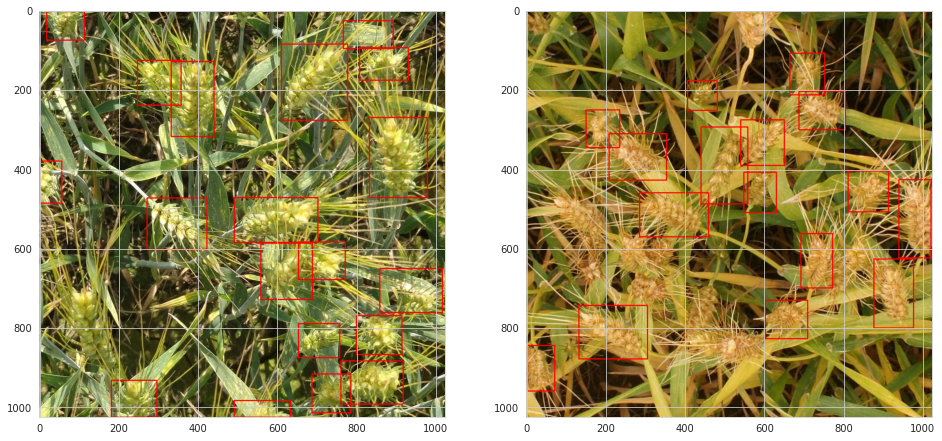

In [35]:
num_rows, num_cols = 1, 2
scale = 16
figsize = (num_rows * scale, num_cols * scale)
_, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
axes = axes.flatten()

fig_n = num_rows * num_cols
fig_i = 0

for i in range(1, 1+fig_n):
  image, image_id = test_dataset[i]
  _, boxes, scores = image_outputs[i]

  sample = image.permute(1, 2, 0).cpu().numpy()

  for box in boxes:
    cv.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (220, 0, 0), 2)

  axes[fig_i].imshow(sample)
  fig_i += 1

### Save Results

In [36]:
def format_prediction_string(boxes, scores):
  pred_strings = []
  for score, box in zip(scores, boxes):
    pred_strings.append(round(score, 4))
    pred_strings.extend(box)
  return ' '.join(map(str, pred_strings))

results = []

for image_id, boxes, scores in image_outputs:
  #boxes = boxes_.copy()
  boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
  boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

  result = {
    'image_id': image_id,
    'PredictionString': format_prediction_string(boxes, scores)
  }
  results.append(result)

results[0]

{'image_id': 'aac893a91',
 'PredictionString': '0.9928 72 2 96 166 0.9925 553 528 123 203 0.9912 613 921 85 102 0.9862 691 392 125 193 0.9855 819 708 105 204 0.9842 356 531 100 88 0.982 586 781 100 119 0.9795 739 768 82 122 0.9779 324 662 126 160 0.9764 27 454 102 156 0.9763 545 76 145 182 0.9736 450 858 90 95 0.9626 241 91 137 146 0.9406 306 0 75 68 0.9404 89 618 128 80 0.9366 177 576 114 182 0.9363 234 845 144 91 0.9265 64 857 115 69 0.824 822 630 90 124 0.7516 815 921 134 100'}

In [37]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df

,image_id,PredictionString
0,aac893a91,0.9928 72 2 96 166 0.9925 553 528 123 203 0.99...
1,51f1be19e,0.9898 272 471 151 130 0.9848 611 83 167 192 0...
2,f5a1f0358,0.975 688 202 117 97 0.9745 151 249 85 95 0.96...
3,796707dd7,0.9314 894 333 109 93 0.88 503 785 98 111 0.83...
4,51b3e36ab,0.9976 532 29 261 145 0.9961 4 430 93 326 0.99...
5,348a992bb,0.9961 1 320 121 103 0.9939 1 468 138 115 0.99...
6,cc3532ff6,0.9944 0 414 151 111 0.9939 773 829 175 172 0....
7,2fd875eaa,0.9957 105 589 142 86 0.995 0 913 109 83 0.994...
8,cb8d261a3,0.8659 19 856 88 156 0.8022 751 712 89 91
9,53f253011,0.9946 927 200 97 144 0.993 19 599 132 158 0.9...


In [38]:
test_df.to_csv('submission.csv', index=False)

### Submit

![](submission.png)

## References

- [TorchVision Instance Segmentation Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)
- [Kaggle: Global Wheat Detection](https://www.kaggle.com/c/global-wheat-detection)
  - [Pytorch Starter - FasterRCNN Train](https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train)
  - [Global Wheat Detection: Starter EDA](https://www.kaggle.com/kaushal2896/global-wheat-detection-starter-eda)